## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from category_encoders import CountEncoder
from sklearn.base import BaseEstimator,TransformerMixin
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score,  roc_auc_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

import os
import joblib

import warnings
warnings.filterwarnings('ignore')
pd.set_option('display.max_columns', 500)

random_state = 4012

In [2]:
import tensorflow as tf
import keras
from keras import backend as K
from keras import models
from keras import utils
from keras.layers import Input,Dense,LSTM,Dropout,Embedding,Bidirectional,concatenate
from keras.models import Model,Sequential
from keras.optimizers import SGD,Adam,RMSprop
from keras.preprocessing.sequence import pad_sequences
from keras.preprocessing.text import one_hot

In [3]:
from scikeras.wrappers import KerasClassifier

## 2. Train Test Split

In [113]:
path = "../Raw Data Files/final_job_posting.csv"
df = pd.read_csv(path)
df.head()
# train test split
X = df['full_text']
y = df['fraudulent']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=random_state,stratify=y)

## 3. Model

In [114]:
# Combine them

scaler = StandardScaler()

onehot = OneHotEncoder(
    categories = [
            ['full time', 'contract', 'part time','flexi','other','unspecified'], # employment_type
            ['entry level', 'middle level', 'senior level', 'unspecified'], # required_experience
            ['high school or vocational degree', 'undergraduate', 'graduate', 'unspecified'], # required_education
    ],
    handle_unknown = 'ignore',  # <- Ignore unknown values (i.e. don't create a column for them)
)

freq_encoder = CountEncoder()

binary_columns = ['telecommuting', 'has_company_logo','has_questions', 'have_company_profile', 'have_requirements', 'have_benefits', 'have_category', 'high_salary']
numerical_columns = ['flesch_score_bin_ft','fk_grade_level_bin_ft', 'text_len']
onehot_columns = ['employment_type', 'required_experience','required_education']
freq_columns = ['location_country']
text_column = ['full_text']

preprocessor = ColumnTransformer([
    # (nickname, transformer to apply, columns to apply to)
    ('binary', 'passthrough', binary_columns),  # <- 'passthrough' says to keep them but don't apply anything
    ('numerical', scaler, numerical_columns),   
    ('onehot', onehot, onehot_columns),
    ('frequency',freq_encoder, freq_columns),
],  remainder='passthrough')


In [115]:
vocab_size=5000
sent_length=128
def text_process(df):
    onehot_repr=[one_hot(words,vocab_size)for words in df] 
    embedded_docs=pad_sequences(onehot_repr,padding='pre',maxlen=sent_length)
    return embedded_docs

In [116]:
X_train_new = text_process(X_train)
X_test_new = text_process(X_test)

In [117]:
# define metrics
def recall_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  possible_positives = K.sum(K.round(K.clip(y_true,0,1)))
  recall = true_positives / (possible_positives + K.epsilon())
  return recall

def precision_m(y_true,y_pred):
  true_positives = K.sum(K.round(K.clip(y_true*y_pred,0,1)))
  predicted_positives = K.sum(K.round(K.clip(y_pred,0,1)))
  precision = true_positives / (predicted_positives + K.epsilon())
  return precision

def f1_m(y_true,y_pred):
  precision = precision_m(y_true,y_pred)
  recall = recall_m(y_true,y_pred)
  return 2*((precision*recall)/(precision+recall+K.epsilon()))

In [118]:
#batch_size = [64, 128]
#dropoutrates = [0.2, 0.3]
epochs = 5
batch_size = 128
dropoutrates = 0.3

In [119]:
embedding_vector_features=50
Bilstm_model=Sequential()
Bilstm_model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
Bilstm_model.add(Bidirectional(LSTM(100))) 
Bilstm_model.add(Dropout(dropoutrates))
Bilstm_model.add(Dense(1,activation='sigmoid'))
Bilstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f1_m])

Bilstm_model.fit(X_train_new,y_train,validation_data=(X_test_new,y_test),epochs=epochs,batch_size=batch_size)

Epoch 1/5
150/150 [==============================] - 115s 721ms/step - loss: 0.1816 - f1_m: 0.3952 - val_loss: 0.0835 - val_f1_m: 0.7395
Epoch 2/5
150/150 [==============================] - 113s 756ms/step - loss: 0.0674 - f1_m: 0.8028 - val_loss: 0.0727 - val_f1_m: 0.7922
Epoch 3/5
150/150 [==============================] - 109s 726ms/step - loss: 0.0396 - f1_m: 0.8902 - val_loss: 0.0710 - val_f1_m: 0.8077
Epoch 4/5
150/150 [==============================] - 102s 677ms/step - loss: 0.0238 - f1_m: 0.9359 - val_loss: 0.0709 - val_f1_m: 0.8021
Epoch 5/5
150/150 [==============================] - 100s 668ms/step - loss: 0.0127 - f1_m: 0.9672 - val_loss: 0.0893 - val_f1_m: 0.8103


In [96]:
## too slow!!
#def create_model(dropoutrates=0.2):
    ## Creating model
    #embedding_vector_features=50
    #Bilstm_model=Sequential()
    #Bilstm_model.add(Embedding(vocab_size,embedding_vector_features,input_length=sent_length))
    #Bilstm_model.add(Bidirectional(LSTM(100))) 
    ##Bilstm_model.add(Dropout(0.3))
    #Bilstm_model.add(Dense(1,activation='sigmoid'))
    #Bilstm_model.compile(loss='binary_crossentropy',optimizer='adam',metrics=[f1_m])
    #return Bilstm_model
#### params
#batch_size = [64, 128]
#dropoutrates = [0.2, 0.3]
#model_CV = KerasClassifier(build_fn=create_model,verbose=0,epochs=10, batch_size=32, dropoutrates=0.2)
# define the grid search parameters
#param_grid = dict(batch_size=batch_size,dropoutrates=dropoutrates)
#grid = GridSearchCV(estimator=model_CV, param_grid=param_grid, cv=3)

#RETURN the grid_result
#grid_result = grid.fit(X_train_new, y_train)

# summarize results
#print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
#means = grid_result.cv_results_['mean_test_score']
#stds = grid_result.cv_results_['std_test_score']
#params = grid_result.cv_results_['params']
#for mean, stdev, param in zip(means, stds, params):
    #print("%f (%f) with: %r" % (mean, stdev, param))

#best_params = grid_result.best_params_
#best_model = grid_result.best_estimator_
#best_params

## 4. Evaluation

In [120]:
def evaluate(x_test,y_test,name,model):

    print(model,"\n")
    
    y_pred = model.predict(X_test_new)
    y_pred = (y_pred > 0.5).astype(int)

    scores = {}
    scores["Accuracy"]  = accuracy_score(y_test,y_pred).round(3)
    scores["Precision"] = precision_score(y_test,y_pred,average="weighted").round(3)
    scores["Recall"]    = recall_score(y_test,y_pred,average="weighted").round(3)
    scores["F1"]        = f1_score(y_test,y_pred,average="weighted").round(3)
    scores["ROC AUC"]   = roc_auc_score(y_test,y_pred,average="weighted").round(3)
    scores = {name:scores}
    print(pd.DataFrame(scores))

    cm = confusion_matrix(y_test,y_pred)
    cm_plot = sns.heatmap(cm, annot=True, fmt='g', cmap='Blues_r')
    cm_plot.set_xlabel('Predicted Values')
    cm_plot.set_ylabel('Actual Values')


150/150 [==============================] - 7s 38ms/step
           BiLSTM(no numeric features)
Accuracy                         0.981
F1                               0.980
Precision                        0.980
ROC AUC                          0.872
Recall                           0.981


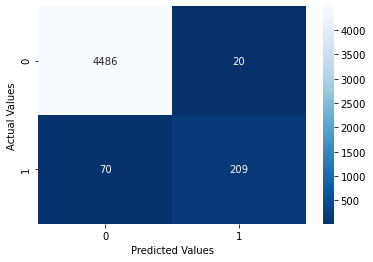

In [121]:
evaluate(X_test_new,y_test,'BiLSTM(no numeric features)',Bilstm_model)